In [1]:
import os
from tqdm import tqdm
from torchvision.datasets import ImageFolder

def create_data_files(image_dir, mask_dir):
    data_files = []
    for dirname, _, filenames in os.walk(image_dir):
        for filename in tqdm(filenames):
            image_path = os.path.join(dirname, filename)

            relative_path = os.path.relpath(image_path, image_dir)

            mask_relative_path = os.path.splitext(relative_path)[0] + "_m" + os.path.splitext(relative_path)[1]
            mask_path = os.path.join(mask_dir, mask_relative_path)

            if os.path.exists(mask_path):
                data_files.append({"image": image_path, "label": mask_path})
            else:
                print(f"Warning: No matching mask for {image_path}")

    return data_files


# Example usage
image_dir = "/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image"
mask_dir = "/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask"

# if os.path.exists(image_dir) and os.path.exists(mask_dir):
#     data_files = create_data_files(image_dir, mask_dir)

#     print(data_files[:5])
# else:
#     print(f"Error: One or both directories do not exist:\nImage Dir: {image_dir}\nMask Dir: {mask_dir}")


In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image

class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform

        self.image_paths = []
        self.mask_paths = []

        for dirname, _, filenames in os.walk(self.image_dir):
            for filename in tqdm(filenames):
                image_path = os.path.join(dirname, filename)
                relative_path = os.path.relpath(image_path, self.image_dir)
                mask_path = os.path.join(self.mask_dir, os.path.splitext(relative_path)[0] + "_m" + os.path.splitext(relative_path)[1])

                if os.path.exists(mask_path):
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)
                else:
                    print(f"Warning: No matching mask for {image_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert("RGB")  # 3 channels
        mask = Image.open(mask_path).convert("L")     # grayscale

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models


class ResUNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResUNet, self).__init__()

        # Pre-trained ResNet backbone (encoder)
        base_model = models.resnet34(pretrained=True)
        self.base_layers = list(base_model.children())
        self.encoder1 = nn.Sequential(*self.base_layers[:3])  # First layer
        self.encoder2 = nn.Sequential(*self.base_layers[3:5])  # Second layer
        self.encoder3 = self.base_layers[5]  # Third layer
        self.encoder4 = self.base_layers[6]  # Fourth layer
        self.encoder5 = self.base_layers[7]  # Fifth layer

        # Decoder
        self.upconv5 = self.upconv(512, 256)
        self.upconv4 = self.upconv(256, 128)
        self.upconv3 = self.upconv(128, 64)
        self.upconv2 = self.upconv(64, 64)
        self.upconv1 = self.upconv(64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def upconv(self, in_channels, out_channels):
        """Upsampling block."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        # Decoder path
        dec5 = self.upconv5(enc5) + enc4
        dec4 = self.upconv4(dec5) + enc3
        dec3 = self.upconv3(dec4) + enc2
        dec2 = self.upconv2(dec3) + enc1
        dec1 = self.upconv1(dec2)

        # Final layer
        out = self.final_conv(dec1)
        return out


In [4]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
# from torchvision.datasets import VOCSegmentation # PASCAL VOC has 21 classes
import torch.optim as optim

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

label_transform = Compose([
    Resize((256, 256)),
    ToTensor(),
])

# train_dataset = VOCSegmentation(root="./data", year="2012", image_set="train", download=True, transform=transform, target_transform=target_transform)
train_dataset = BrainTumorSegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=transform,
    target_transform=label_transform
)

image, mask = train_dataset[0]
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

0it [00:00, ?it/s]
100%|██████████| 649/649 [00:01<00:00, 480.15it/s]


Image shape: torch.Size([3, 256, 256]), Mask shape: torch.Size([1, 256, 256])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet(num_classes=4).to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        # Forward
        outputs = model(images)
        
        loss = criterion(outputs, masks.squeeze().long())
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Done")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]
100%|██████████| 530/530 [02:08<00:00,  4.12it/s]


Epoch 1/50, Loss: 436.6741


100%|██████████| 530/530 [01:30<00:00,  5.87it/s]


Epoch 2/50, Loss: 142.8194


100%|██████████| 530/530 [01:31<00:00,  5.78it/s]


Epoch 3/50, Loss: 58.1657


100%|██████████| 530/530 [01:30<00:00,  5.84it/s]


Epoch 4/50, Loss: 29.9827


100%|██████████| 530/530 [01:29<00:00,  5.89it/s]


Epoch 5/50, Loss: 17.7104


100%|██████████| 530/530 [01:28<00:00,  5.99it/s]


Epoch 6/50, Loss: 11.4374


100%|██████████| 530/530 [01:28<00:00,  6.00it/s]


Epoch 7/50, Loss: 8.0951


100%|██████████| 530/530 [01:28<00:00,  5.98it/s]


Epoch 8/50, Loss: 6.0490


100%|██████████| 530/530 [01:28<00:00,  5.96it/s]


Epoch 9/50, Loss: 4.7346


100%|██████████| 530/530 [01:28<00:00,  5.98it/s]


Epoch 10/50, Loss: 3.6838


100%|██████████| 530/530 [01:29<00:00,  5.94it/s]


Epoch 11/50, Loss: 3.1303


100%|██████████| 530/530 [01:29<00:00,  5.95it/s]


Epoch 12/50, Loss: 2.4693


100%|██████████| 530/530 [01:28<00:00,  5.97it/s]


Epoch 13/50, Loss: 2.0608


100%|██████████| 530/530 [01:27<00:00,  6.03it/s]


Epoch 14/50, Loss: 1.8285


100%|██████████| 530/530 [01:27<00:00,  6.05it/s]


Epoch 15/50, Loss: 1.6104


100%|██████████| 530/530 [01:28<00:00,  6.01it/s]


Epoch 16/50, Loss: 1.4479


100%|██████████| 530/530 [01:28<00:00,  6.01it/s]


Epoch 17/50, Loss: 1.3306


100%|██████████| 530/530 [01:28<00:00,  5.98it/s]


Epoch 18/50, Loss: 1.2073


100%|██████████| 530/530 [01:29<00:00,  5.94it/s]


Epoch 19/50, Loss: 1.0829


100%|██████████| 530/530 [01:29<00:00,  5.91it/s]


Epoch 20/50, Loss: 1.0556


100%|██████████| 530/530 [01:30<00:00,  5.84it/s]


Epoch 21/50, Loss: 1.5816


100%|██████████| 530/530 [01:32<00:00,  5.71it/s]


Epoch 22/50, Loss: 1.1350


100%|██████████| 530/530 [01:32<00:00,  5.73it/s]


Epoch 23/50, Loss: 0.8601


100%|██████████| 530/530 [01:33<00:00,  5.66it/s]


Epoch 24/50, Loss: 0.7577


100%|██████████| 530/530 [01:29<00:00,  5.90it/s]


Epoch 25/50, Loss: 0.7094


100%|██████████| 530/530 [01:28<00:00,  5.98it/s]


Epoch 26/50, Loss: 0.6840


100%|██████████| 530/530 [01:28<00:00,  5.96it/s]


Epoch 27/50, Loss: 0.6701


100%|██████████| 530/530 [01:28<00:00,  6.00it/s]


Epoch 28/50, Loss: 0.6819


100%|██████████| 530/530 [01:28<00:00,  6.00it/s]


Epoch 29/50, Loss: 0.6327


100%|██████████| 530/530 [01:28<00:00,  5.99it/s]


Epoch 30/50, Loss: 0.6135


100%|██████████| 530/530 [01:28<00:00,  6.01it/s]


Epoch 31/50, Loss: 0.6201


100%|██████████| 530/530 [01:28<00:00,  5.97it/s]


Epoch 32/50, Loss: 0.6009


100%|██████████| 530/530 [01:28<00:00,  6.01it/s]


Epoch 33/50, Loss: 0.5701


100%|██████████| 530/530 [01:28<00:00,  5.99it/s]


Epoch 34/50, Loss: 0.5494


100%|██████████| 530/530 [01:27<00:00,  6.03it/s]


Epoch 35/50, Loss: 0.5312


100%|██████████| 530/530 [01:28<00:00,  6.02it/s]


Epoch 36/50, Loss: 0.5164


100%|██████████| 530/530 [01:28<00:00,  6.02it/s]


Epoch 37/50, Loss: 0.5283


100%|██████████| 530/530 [01:27<00:00,  6.04it/s]


Epoch 38/50, Loss: 0.5222


100%|██████████| 530/530 [01:27<00:00,  6.03it/s]


Epoch 39/50, Loss: 0.4687


100%|██████████| 530/530 [01:27<00:00,  6.04it/s]


Epoch 40/50, Loss: 0.4475


100%|██████████| 530/530 [01:28<00:00,  6.02it/s]


Epoch 41/50, Loss: 0.4460


100%|██████████| 530/530 [01:28<00:00,  5.97it/s]


Epoch 42/50, Loss: 0.4428


100%|██████████| 530/530 [01:28<00:00,  5.97it/s]


Epoch 43/50, Loss: 0.4397


100%|██████████| 530/530 [01:28<00:00,  5.99it/s]


Epoch 44/50, Loss: 0.4293


100%|██████████| 530/530 [01:28<00:00,  5.99it/s]


Epoch 45/50, Loss: 0.4168


100%|██████████| 530/530 [01:28<00:00,  5.99it/s]


Epoch 46/50, Loss: 0.4080


100%|██████████| 530/530 [01:28<00:00,  5.98it/s]


Epoch 47/50, Loss: 0.3955


100%|██████████| 530/530 [01:28<00:00,  6.00it/s]


Epoch 48/50, Loss: 0.3838


100%|██████████| 530/530 [01:29<00:00,  5.95it/s]


Epoch 49/50, Loss: 1.1860


100%|██████████| 530/530 [01:28<00:00,  6.00it/s]

Epoch 50/50, Loss: 0.7147
Done


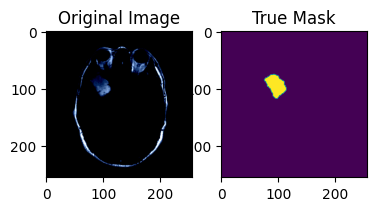

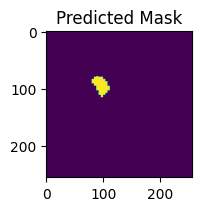

In [6]:
import matplotlib.pyplot as plt

#eval
model.eval()
test_image, test_mask = train_dataset[80]
test_image = test_image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_image)
    predicted_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# Plot original image and predicted mask
plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(test_mask.permute(1, 2, 0).cpu().numpy())
plt.title("True Mask")
plt.show()

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title("Predicted Mask")
plt.show()